In [1]:
# -*- coding: utf-8 -*-

# This is a report using the data from IQAASL.
# IQAASL was a project funded by the Swiss Confederation
# It produces a summary of litter survey results for a defined region.
# These charts serve as the models for the development of plagespropres.ch
# The data is gathered by volunteers.
# Please remember all copyrights apply, please give credit when applicable
# The repo is maintained by the community effective January 01, 2022
# There is ample opportunity to contribute, learn and teach
# contact dev@hammerdirt.ch

# Dies ist ein Bericht, der die Daten von IQAASL verwendet.
# IQAASL war ein von der Schweizerischen Eidgenossenschaft finanziertes Projekt.
# Es erstellt eine Zusammenfassung der Ergebnisse der Littering-Umfrage für eine bestimmte Region.
# Diese Grafiken dienten als Vorlage für die Entwicklung von plagespropres.ch.
# Die Daten werden von Freiwilligen gesammelt.
# Bitte denken Sie daran, dass alle Copyrights gelten, bitte geben Sie den Namen an, wenn zutreffend.
# Das Repo wird ab dem 01. Januar 2022 von der Community gepflegt.
# Es gibt reichlich Gelegenheit, etwas beizutragen, zu lernen und zu lehren.
# Kontakt dev@hammerdirt.ch

# Il s'agit d'un rapport utilisant les données de IQAASL.
# IQAASL était un projet financé par la Confédération suisse.
# Il produit un résumé des résultats de l'enquête sur les déchets sauvages pour une région définie.
# Ces tableaux ont servi de modèles pour le développement de plagespropres.ch
# Les données sont recueillies par des bénévoles.
# N'oubliez pas que tous les droits d'auteur s'appliquent, veuillez indiquer le crédit lorsque cela est possible.
# Le dépôt est maintenu par la communauté à partir du 1er janvier 2022.
# Il y a de nombreuses possibilités de contribuer, d'apprendre et d'enseigner.
# contact dev@hammerdirt.ch

# sys, file and nav packages:
import datetime as dt
# for date and month formats in french or german
import locale

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.sr_ut as sut
import resources.chart_kwargs as ck

# images and display
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display

from myst_nb import glue

# set the locale to the language desired
# the locale is set back to to original at the the end of the script
# set the locale to the language desired
# the locale is set back to to original at the the end of the script
loc = locale.getlocale()
lang =  "de_DE.utf8"
locale.setlocale(locale.LC_ALL, lang)

# the date is in iso standard:
d = "%Y-%m-%d"

# it gets changed to german format
g = "%d.%m.%Y"

# set some parameters:
start_date = "01.03.2020"
end_date ="31.09.2021"
start_end = [start_date, end_date]
a_fail_rate = 50
unit_label = "p/100m"
reporting_unit = 100
a_color = "dodgerblue"

# colors for gradients and charts
cmap2 = ck.cmap2
colors_palette = ck.colors_palette

# colors for the individual survey areas
bassin_pallette = {"rhone":"dimgray", "aare":"salmon", "linth":"tan", "ticino":"steelblue", "reuss":"purple"}

# set the maps
bassin_map = "resources/maps/lakes_rivers_map.jpeg"

# define the feature level and components
this_level = "river_bassin"
comps = ["linth", "rhone", "aare", "ticino"]

# proper labels for charts and tables
comp_labels = {"linth":"Linth/Limmat", "rhone":"Rhône", "aare":"Aare", "ticino":"Ticino/Cerisio", "reuss":"Reuss"}
top_name = ["Alle Erhebungsgebiete"]

# explanatory variables:
luse_exp =  list(sut.luse_ge.values())

# common aggregations
agg_pcs_quantity = {unit_label:"sum", "quantity":"sum"}
agg_pcs_median = {unit_label:"median", "quantity":"sum"}

# aggregation of dimensional data
agg_dims = {"total_w":"sum", "mac_plast_w":"sum", "area":"sum", "length":"sum"}

# columns needed
use_these_cols = ["loc_date" ,
                  "% buildings",
                  "% to trans", 
                  "% recreation",
                  "% ag",
                  "% woods",
                  "population",
                  this_level,
                  "water_name_slug",
                  "streets km",
                  "intersects",
                  "length",
                  "groupname",
                  "code"
                 ]

# get the data:
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index("slug", inplace=True)

# make any adjustments to code definitions here:
dfCodes.set_index("code", inplace=True)

# the surveyor designated the object as aluminum instead of metal
dfCodes.loc["G708", "material"] = "Metal"

# language specific
# importing german code descriptions
de_codes = pd.read_csv("resources/codes_german_Version_1.csv")
de_codes.set_index("code", inplace=True)

for x in dfCodes.index:
    dfCodes.loc[x, "description"] = de_codes.loc[x, "german"]

# there are long code descriptions that may need to be shortened for display
# there are long code descriptions that may need to be shortened for display
codes_to_change = [
    ["G704", "description", "Seilbahnbürste"],
    ["Gfrags", "description", "Fragmentierte Kunststoffstücke"],
    ["G30", "description", "Snack-Verpackungen"],
    ["G124", "description", "Kunststoff-oder Schaumstoffprodukte"],
    ["G87", "description", "Abdeckklebeband/Verpackungsklebeband"],
    ["G178","description","Flaschenverschlüsse aus Metall"],
    ["G3","description","Einkaufstaschen, Shoppingtaschen"],
    ["G33", "description", "Einwegartikel; Tassen/Becher & Deckel"],
    ["G31", "description", "Schleckstengel, Stengel von Lutscher"],
    ["G211", "description", "Sonstiges medizinisches Material"],
    ["G904", "description", "Feuerwerkskörper; Raketenkappen"],
    ["G940", "description", "Schaumstoff EVA (flexibler Kunststoff)"]
]

# apply changes
for x in codes_to_change:
    dfCodes = sut.shorten_the_value(x, dfCodes)

dfCodes["material"] = dfCodes.material.map(lambda x: sut.mat_ge[x]) 

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(allsurveysde)=
# Seen und Flüsse

Karte der Erhebungsorte IQAASL März 2020 - Mai 2021.

In [2]:
# sut.display_image_ipython(bassin_map, thumb=(800,450))

```{figure} resources/maps/lakes_rivers_map.jpeg
:figwidth: 800px
:name: "eosmap_de"

` `

```

{numref}`Abbildung {number} <eosmap_de>`: Die Standorte der Erhebungen sind für die Analyse nach Erhebungsgebiet gruppiert. Die Größe der Markierung stellt den Median der Gesamtzahl der Erhebungen für diesen Ort dar. 

## Profil der Landnutzung

Die Erhebungsgebiete sind nach Flusseinzugsgebieten gruppiert. In diesem Bericht werden mehrere Einzugsgebiete zusammengefasst, um regionale Trends zu analysieren: 

* Aare: Emme, Aare 
* Linth/Limmat: Reuss, Linth, Limmat 
* Rhône: Rhône 
* Tessin/Ceresio: Tessin, Lago di Lugano, Lago Maggiore 

Das Landnutzungsprofil ist der prozentuale Anteil der Gesamtfläche, der jeder Landnutzungskategorie innerhalb eines Radius von 1'500 m um jeden Erhebungsort zugeordnet ist.       

* \% auf Gebäude entfallen 
* \% der landwirtschaftlich genutzten Fläche 
* \% der Fläche, die der Forstwirtschaft zugeschrieben wird 
* \% der Fläche, die der Erholung vorbehalten ist 

Straßen werden als Gesamtzahl der Straßenkilometer im Umkreis von 1500 m angegeben. Intersects ist ebenfalls eine ordinale Rangfolge der Anzahl der Flüsse/Kanäle, die einen See innerhalb von 1500 m um den Erhebungsort herum durchqueren.  

Das Verhältnis der Anzahl der Proben bei unterschiedlichen Landnutzungsprofilen gibt einen Hinweis auf die ökologischen und wirtschaftlichen Bedingungen der Untersuchungsstandorte. 

Für weitere Informationen [_Landnutzungsprofil_](luseprofilede)

__Verteilung der Landnutzungsmerkmale__

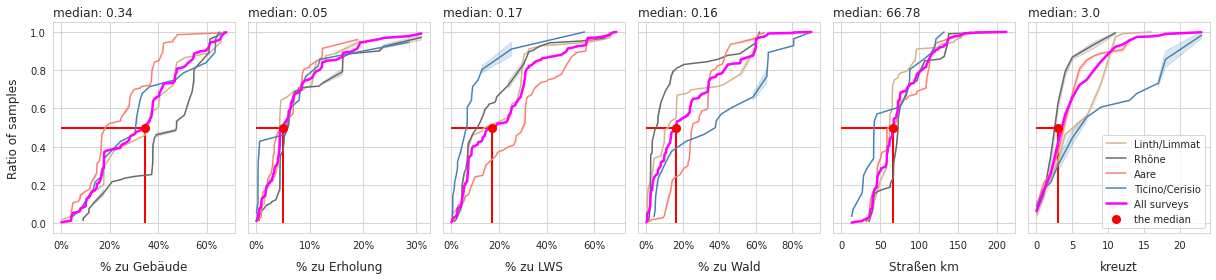

In [3]:
# this is the data before the expanded fragmented plastics and foams are aggregated to Gfrags and Gfoams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")
before_agg["loc_date"] = list(zip(before_agg.location, before_agg["date"]))

# this is the aggregated survey data that is being used
fd = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")
fd["loc_date"] = list(zip(fd.location, fd["date"]))

# apply local date configuration
fd["date"] = pd.to_datetime(fd["date"])
fd["date"] = fd["date"].dt.strftime(g)
fd["date"] = pd.to_datetime(fd["date"], format=g)

fd["groupname"] = fd["groupname"].map(lambda x: sut.group_names_de[x])
fd.rename(columns=sut.luse_ge, inplace=True)

# cumulative statistics for each code
code_totals = sut.the_aggregated_object_values(fd, agg=agg_pcs_median, description_map=code_description_map, material_map=code_material_map)    

dt_nw = fd.groupby(["loc_date", "river_bassin", *luse_exp], as_index=False).agg({unit_label:"sum"})

sns.set_style("whitegrid")

fig, axs = plt.subplots(1,len(luse_exp), figsize=(17,4), sharey=True)

for i, n in enumerate(luse_exp):
    # get the dist for each survey area here
    for element in comps:
        ax=axs[i]
        the_data = ECDF(dt_nw[dt_nw[this_level] == element][n].values)
        sns.lineplot(x=the_data.x, y=the_data.y, ax=ax, label=comp_labels[element], color=bassin_pallette[element])
    
    # get the dist for all here
    a_all_surveys =  ECDF(dt_nw[n].values)
    sns.lineplot(x=a_all_surveys.x, y=a_all_surveys.y, ax=ax, label="All surveys", color="magenta", linewidth=2.5)
 
    # get the median from the data
    the_median = np.median(dt_nw[n].values)
    
    # plot the median and drop horzontal and vertical lines
    ax.scatter([the_median], 0.5, color="red",s=50, linewidth=2, zorder=100, label="the median")
    ax.vlines(x=the_median, ymin=0, ymax=0.5, color="red", linewidth=2)
    ax.hlines(xmax=the_median, xmin=0, y=0.5, color="red", linewidth=2)
    
    # format the % of total on the xaxis:
    if i <= 3:
        if i == 0:            
            ax.set_ylabel("Ratio of samples", **ck.xlab_k)
        ax.xaxis.set_major_formatter(ticker.PercentFormatter(1.0, 0, "%"))        
    else:
        pass
    
    ax.set_xlabel(n, **ck.xlab_k)
    handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    ax.set_title(F"median: {(round(the_median, 2))}",fontsize=12, loc="left")

plt.legend(handles, labels)       
plt.tight_layout()

glue("eosluse_de", fig, display=False)
plt.close() 

```{glue:figure} eosluse_de
---
name: "eos_luse_de"
---

` `

```
{numref}`Abbildung {number}: <eos_luse_de>` Die Erhebungen in den Gebieten Rhône und Linth/Limmat wiesen mit 47 % bzw. 40 % im Median den größten Anteil an bebauter Fläche und mit 5 % bzw. 8 % den geringsten Anteil an Wald auf. Im Erhebungsgebiet Aare war der Medianwert der bebauten Fläche mit 16 % am niedrigsten und der Anteil der landwirtschaftlich genutzten Fläche mit 30 % am höchsten. Bei den Flächen, die der Erholung zugeordnet werden, handelt es sich um Sportplätze, öffentliche Strände und andere öffentliche Versammlungsorte.

### Kumulierte Gesamtergebnisse nach Erhebungsgebiet 

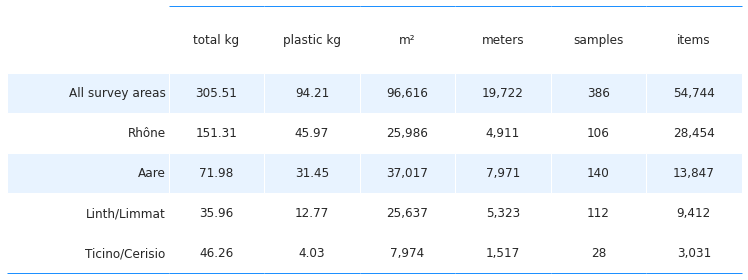

In [4]:
# aggregate the dimensional data
dims_parameters = dict(this_level=this_level, 
                       locations=fd.location.unique(), 
                       start_end=start_end, 
                       agg_dims=agg_dims)

dims_table = sut.gather_dimensional_data(dfDims, **dims_parameters)

dt_all = fd.groupby(["loc_date","location",this_level, "city","date"], as_index=False).agg({unit_label:"sum", "quantity":"sum"})

for name in dims_table.index:
    dims_table.loc[name, "samples"] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, "quantity"] =fd[fd[this_level] == name].quantity.sum()

# add proper names for display
dims_table["Survey area"] = dims_table.index.map(lambda x: comp_labels[x])
dims_table.set_index("Survey area", inplace=True)
   
# get the sum of all survey areas
dims_table.loc["All survey areas"]= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={"samples":"samples","quantity":"items", "total_w":"total kg", "mac_plast_w":"plastic kg", "area":"m²", "length":"meters"}, inplace=True)

# format kilos and text strings
dims_table["plastic kg"] = dims_table["plastic kg"]/1000
dims_table[["m²", "meters", "samples", "items"]] = dims_table[["m²", "meters", "samples", "items"]].applymap(lambda x: "{:,}".format(int(x)))
dims_table[["plastic kg", "total kg"]] = dims_table[["plastic kg", "total kg"]].applymap(lambda x: "{:.2f}".format(x))

data = dims_table.reset_index()

fig, axs = plt.subplots(figsize=(len(data.columns)*1.5,len(data)*.8))
sut.hide_spines_ticks_grids(axs)

table_one = sut.make_a_table(axs, data.values, colLabels=data.columns, colWidths=[.22, *[.13]*6],a_color=a_color)
table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
glue("eos_summary_sarea_de", fig, display=False)
plt.close()

```{glue:figure} eos_summary_sarea_de
:name: "eos_summary_sarea_de"


` `

```

{numref}`Abbildung {number}: <eos_summary_sarea_de>` Summen der Dimensionsergebnisse für alle Erhebungsgebiete. Das Aare-Erhebungsgebiet hatte die größte Anzahl von Proben und die geringste Anzahl von gesammelten Objekten.  

## Erhebungsergebnisse für alle Objekte

Verteilung der Erhebungsergebnisse. Die Werte werden als die Anzahl der identifizierten Stücke pro 100 Meter (p/100 m) dargestellt. 

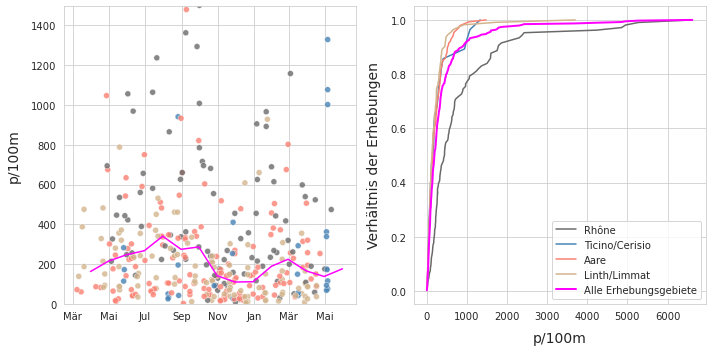

In [5]:
# the surveys to chart
dt_all["date"] = pd.to_datetime(dt_all["date"], format="%Y-%m-%d")
fd_n_samps = dt_all.loc_date.nunique()
fd_dindex = dt_all.set_index("date")

# monthly median survey total
monthly_plot = fd_dindex[unit_label].resample("M").median()

# scale the chart as needed to accomodate for extreme values
y_lim = 95
y_limit = np.percentile(dt_all[unit_label], y_lim)

# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months_loc = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter("%b")

fig, axs = plt.subplots(1,2, figsize=(10,5))

rate = "Monthly"

line_label = "monthly median"

ax = axs[0]
sns.scatterplot(data=fd_dindex, x="date", y=unit_label, hue=this_level, palette=bassin_pallette, alpha=0.8, ax=ax)

sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, color="magenta", label=line_label, ax=ax)

ax.set_ylim(0,y_limit)

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_major_formatter(months_fmt)
ax.get_legend().remove()

axtwo = axs[1]
lake_dts = fd.groupby([this_level, "loc_date"], as_index=False)[unit_label].sum()

for i, a_name in enumerate(fd[this_level].unique()):
    label=comp_labels[a_name]
    
    a_ecdf = ECDF(lake_dts[lake_dts[this_level] == a_name][unit_label].values)
    
    sns.lineplot(x=a_ecdf.x, y=a_ecdf.y, color=bassin_pallette[a_name], ax=axtwo, label=label)

r_bassin = ECDF(dt_all[unit_label].values)

sns.lineplot(x=r_bassin.x, y=r_bassin.y, color="magenta", label=top_name[0], linewidth=2, ax=axtwo)

axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Verhältnis der Erhebungen", **ck.xlab_k14)

plt.tight_layout()

glue("eosscatter_de", fig, display=False)
# plt.show()
plt.close()

```{glue:figure} eosscatter_de
:name: "eos_scatter_de"


` `

```

{numref}`Abbildung {number}: <eos_scatter_de>` __Links:__ Alle Erhebungen von 2020-03 bis 2021-05 gruppiert nach Erhebungsgebiet und aggregiert zum monatlichen Median. Werte über 2324,3 p/100 m sind nicht dargestellt. __Rechts:__ Die empirische kumulative Verteilung der Gesamtwerte der Erhebungen. 

__Zusammenfassende Daten und Materialtypen__

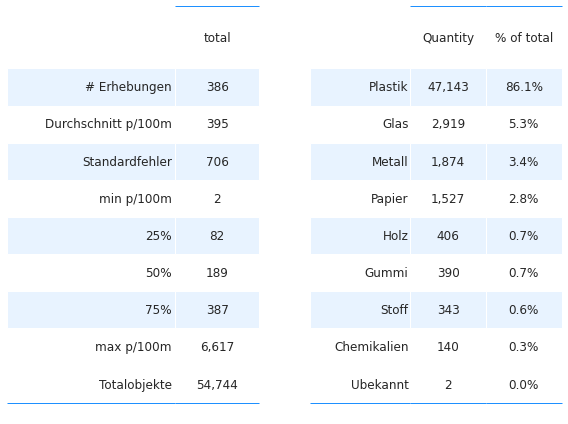

In [6]:
# get the basic statistics from pd.describe
cs = dt_all[unit_label].describe().round(2)

# add project totals
cs["total objects"] = dt_all.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="DE"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

fd_mat_totals = sut.the_ratio_object_to_total(code_totals)
fd_mat_totals = sut.fmt_pct_of_total(fd_mat_totals)
fd_mat_totals = sut.make_string_format(fd_mat_totals)

# applly new column names for printing
cols_to_use = {"material":"Material","quantity":"Quantity", "% of total":"% of total"}
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = ["All survey areas", "total"]

axone = axs[0]
sut.hide_spines_ticks_grids(axone)

table_two = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_two.get_celld()[(0,0)].get_text().set_text(" ")

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
sut.hide_spines_ticks_grids(axtwo)

table_three = sut.make_a_table(axtwo, fd_mat_t,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_three.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
glue("summarymaterial_de", fig, display=False)
plt.close()

```{glue:figure} summarymaterial_de
:name: "summarymaterial_de"

` `
```

{numref}`Abbildung {number}: <summarymaterial_de>` __Links:__ Zusammenfassung der Erhebungen insgesamt für alle Erhebungsgebiete. __Rechts:__ Materialtypen und Prozentsatz der Gesamtmenge für alle Erhebungsgebiete. 

In [7]:
# # figure caption
# material_type = F"""
# *__Right:__ {top_name[0]} material type and percent of total*
# """
# md(material_type)

## Die häufigsten Objekte

Die häufigsten Objekte sind __die zehn mengenmäßig am häufigsten vorkommenden Objekte, UND/ODER Objekte, die in mindestens 50% aller Datenerhebungen identifiziert wurden__. 

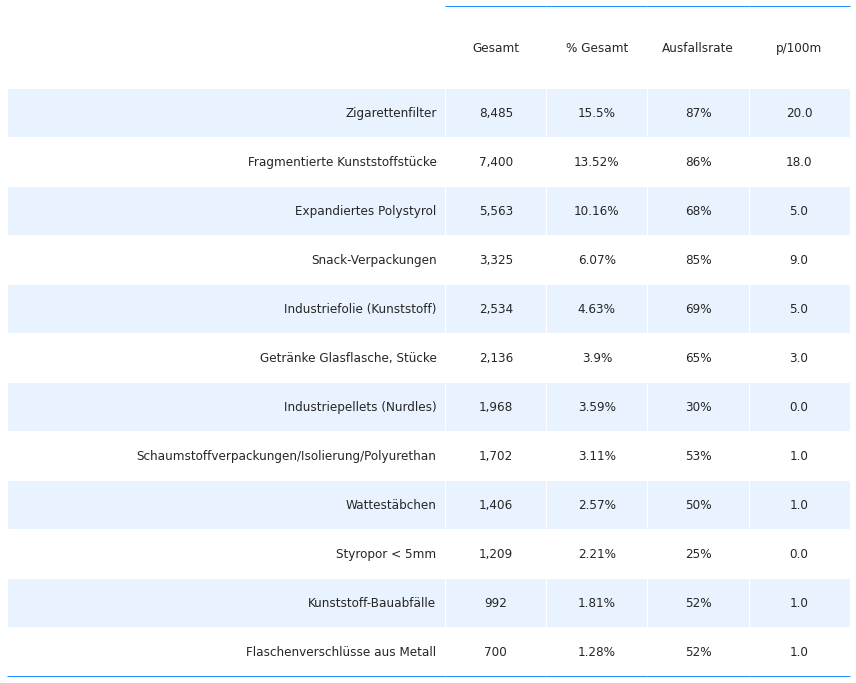

In [8]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by="quantity", ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] >= a_fail_rate ].sort_values(by="quantity", ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# format values for table
m_common["item"] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common["% of total"] = m_common["% of total"].map(lambda x: F"{x}%")
m_common["quantity"] = m_common.quantity.map(lambda x: "{:,}".format(x))
m_common["fail rate"] = m_common["fail rate"].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{np.ceil(x)}")

cols_to_use = {"item":"Objekt","quantity":"Gesamt", "% of total":"% Gesamt", "fail rate":"Ausfallsrate", unit_label:unit_label}

# final table data
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(12,len(m_common)*.5))

sut.hide_spines_ticks_grids(axs)

table_four = sut.make_a_table(axs, all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_four.get_celld()[(0,0)].get_text().set_text(" ")


plt.tight_layout()
glue("mcommoneos_de", fig, display=False)
plt.close()

```{glue:figure} mcommoneos_de
:name: "mcommon_eos_de"

` `

```

{numref}`Abbildung {number}: <mcommon_eos_de>` Die häufigsten Objekte für alle Erhebungsgebiete. Die Fail-Pass-Rate gibt an, wie oft ein Objekt in Bezug auf die Anzahl der Erhebungen identifiziert wurde. Zusammengenommen machen die häufigsten Objekte 68 % aller gefundenen Objekte aus.  

__Häufigste Objekte im Median p/100m nach Erhebungsgebiet__

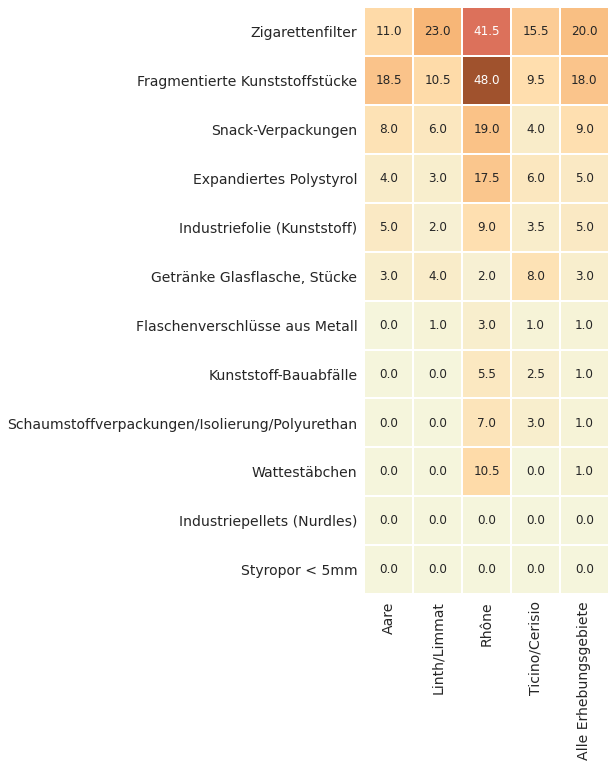

In [9]:
# aggregated survey totals for the most common codes for all the survey areas
# aggregate the code totals by survey and then get the median value per survey
m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, "loc_date","code"], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, "code"], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft["f_name"] = m_common_ft[this_level].map(lambda x: comp_labels[x])

# map the desctiption to the code
m_common_ft["item"] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[["item", unit_label, "f_name"]].pivot(columns="f_name", index="item")

# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals of all the data
a_s_a = fd[fd.code.isin(m_common.index)].groupby(["water_name_slug", "loc_date", "code"], as_index=False).agg(agg_pcs_quantity)
a_s_a_cols = sut.aggregate_to_code(a_s_a, code_description_map,name=top_name[0])

ad_t_ten = pd.concat([m_c_p, a_s_a_cols], axis=1).sort_values(by=top_name[0], ascending=False)

# chart that
fig, ax  = plt.subplots(figsize=(len(ad_t_ten.columns)*.9,len(ad_t_ten)*.9))
axone = ax

sns.heatmap(ad_t_ten, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both")

plt.setp(axone.get_xticklabels(), rotation=90)

glue("mcommonpcs_de", fig, display=False)
plt.close()

```{glue:figure} mcommonpcs_de
:name: "mcommon_pcs_de"

` `

```

{numref}`Abbildung {number}: <mcommon_pcs_de>` Der Median p/100 m der häufigsten Objekte für alle Erhebungsgebiete. Die Raten, mit denen die häufigsten Objekte identifiziert werden, sind für jedes Erhebungsgebiet unterschiedlich.  

__Häufigste Objekte im Monatsdurchschnitt__

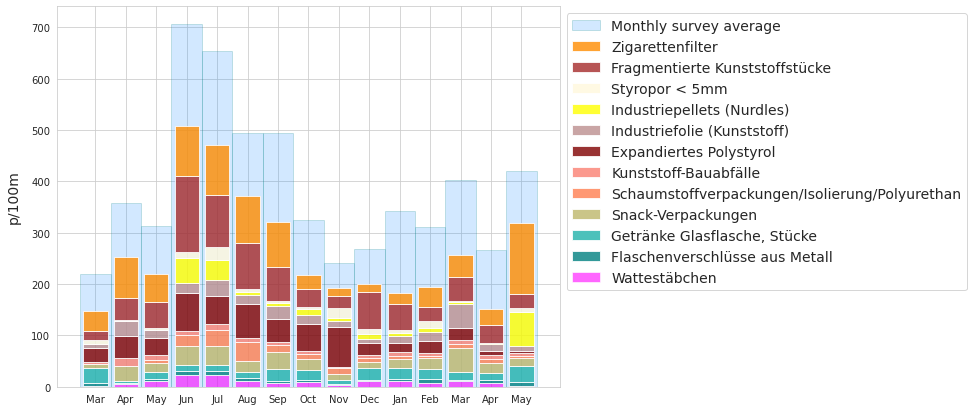

In [10]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(["loc_date","date","code", "groupname"], as_index=False).agg(agg_pcs_quantity)
m_common_m["date"] = pd.to_datetime(m_common_m["date"], format="%Y-%m-%d")
m_common_m.set_index("date", inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(["code","groupname"], as_index=False).quantity.sum().sort_values(by="groupname")["code"].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample("M").mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

months={
    0:"Jan",
    1:"Feb",
    2:"Mar",
    3:"Apr",
    4:"May",
    5:"Jun",
    6:"Jul",
    7:"Aug",
    8:"Sep",
    9:"Oct",
    10:"Nov",
    11:"Dec"
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(9,7))

# define a bottom
bottom = [0]*len(mgr["G27"])

# the monhtly survey average for all objects and locations
monthly_fd = dt_all.copy()
monthly_fd.set_index("date", inplace=True)
m_fd = monthly_fd[unit_label].resample("M").mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color=a_color, alpha=0.2, linewidth=1, edgecolor="teal", width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)
glue("monthlyeos_de", fig, display=False)
plt.close()

```{glue:figure} monthlyeos_de
:name: "monthly_eos_de"


` `

```

{numref}`Abbildung {number}: <monthly_eos_de>` Monatliches Durchschnittsergebnis der Erhebungen als p/100 m der häufigsten Objekte für alle Erhebungsgebiete. 

## Erhebungsergebnisse und Landnutzung 

Die Erhebungsergebnisse in Bezug auf die Landnutzung auf nationaler Ebene werden ausführlich in Das [ Landnutzungsprofil ](luseprofilede) and [Shared responsibility - english](transportde).

## Nutzen der gefundenen Objekte 

Die Nutzungsart basiert auf der Verwendung des Objekts, bevor es weggeworfen wurde, oder auf der Artikelbeschreibung, wenn die ursprüngliche Verwendung unbestimmt ist. Identifizierte Objekte werden in eine der vordefinierten Kategorien eingeordnet. Die Kategorien werden je nach Verwendung oder Artikelbeschreibung gruppiert.

*  **Abwasser:** Gegenstände, die aus Kläranlagen freigesetzt werden, einschließlich Gegenstände, die wahrscheinlich über die Toilette entsorgt werden   
*  **Mikroplastik (< 5 mm):** zersplitterte Kunststoffe und Kunststoffharze aus der Vorproduktion
*  **Infrastruktur:** Artikel im Zusammenhang mit dem Bau und der Instandhaltung von Gebäuden, Straßen und der Wasser-/Stromversorgung  
*  **Essen und Trinken:** alle Materialien, die mit dem Konsum von Essen und Trinken in Zusammenhang stehen
*  **Landwirtschaft:** vor allem Industriefolien, z. B. für Mulch und 
*  **Tabak:** hauptsächlich Zigarettenfilter, einschließlich aller mit dem Rauchen verbundenen Materialien 
*  **Freizeit und Erholung:** Objekte, die mit Sport und Freizeit zu tun haben, z. B. Angeln, Jagen, Wandern usw. 
*  **Verpackungen außer Lebensmittel und Getränke:** Verpackungsmaterial, das nicht als lebensmittel-, getränke- oder tabakbezogen gekennzeichnet ist
*  **Plastikfragmente:** Plastikteile unbestimmter Herkunft oder Verwendung  
*  **Persönliche Gegenstände:** Accessoires, Hygieneartikel und Kleidung 

Im Anhang finden Sie die vollständige Liste der identifizierten Objekte, einschließlich Beschreibungen und Gruppenklassifizierung. Der Abschnitt [Codegruppen](codegroupsde) beschreibt jede Codegruppe im Detail und bietet eine umfassende Liste aller Objekte in einer Gruppe. 

Der Nutzungszweck oder die Beschreibung der identifizierten Objekte in % der Gesamtfläche der Erhebung. 

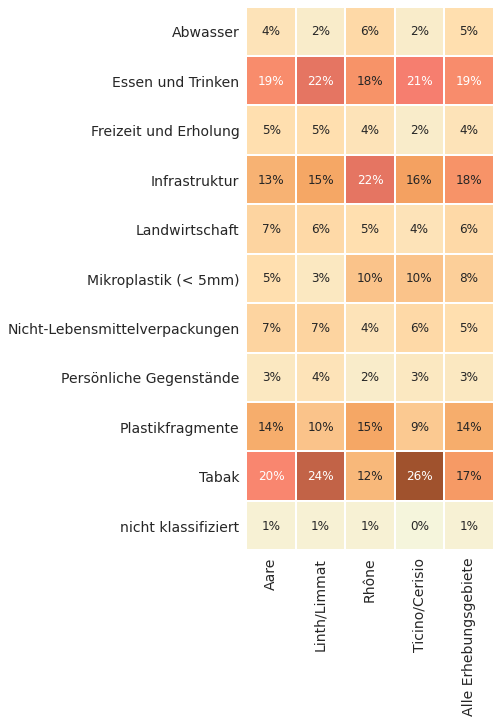

In [11]:
# code groups aggregated by survey for each survey area
groups = ["loc_date","groupname"]
cg_t = fd.groupby([this_level,"loc_date", "groupname"], as_index=False).agg(agg_pcs_quantity)

# aggregate all that for each survey area
cg_t = cg_t.groupby([this_level, "groupname"], as_index=False).agg({unit_label:"median", "quantity":"sum", "loc_date":"nunique"})

# quantity per water survey area
cg_tq = cg_t.groupby(this_level).quantity.sum()

# assign survey area total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, "f_total"] = cg_tq.loc[a_feature]

# get the percent of total for each group for each survey area
cg_t["pt"] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index="groupname", values="pt")

data_table[top_name[0]] = sut.aggregate_to_group_name(fd, unit_label=unit_label, column="groupname", name=top_name[0], val="pt")
data_table.rename(columns={x:comp_labels[x] for x in data_table.columns[:-1]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data_table, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt=".0%", linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)
glue("utility_de", fig, display=False)

plt.close()

```{glue:figure} utility_de
:name: "utility_eos_de"


` `

```

{numref}`Abbildung {number}: <utility_eos_de>` Der Nutzungszweck der Objekte in % der Gesamtmenge für die Erhebungsgebiete.

In [12]:
cg_medpcm = F"""
{top_name[0]} utility of objects found median {unit_label}. Fragmented objects with no clear identification remain classified by size:
"""
md(cg_medpcm)


Alle Erhebungsgebiete utility of objects found median p/100m. Fragmented objects with no clear identification remain classified by size:


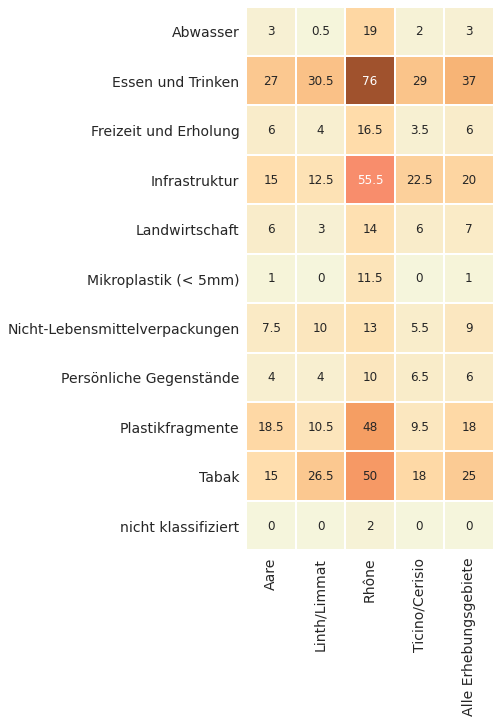

In [13]:
# median p/50m solve cg_t for unit_label
data_table = cg_t.pivot(columns=this_level, index="groupname", values=unit_label)

# column for all the data
a = fd.groupby(["groupname", "loc_date"], as_index=False)[unit_label].sum()
a[top_name[0]] = a[unit_label]
a = a.groupby("groupname")[top_name[0]].median()

# stick that together
data = pd.concat([data_table, a], axis=1)

# format for display
data.rename(columns={x:comp_labels[x] for x in data.columns[:-1]}, inplace=True)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt="g", cbar=False, linewidth=.1, square=True, linecolor="white")

axone.set_xlabel("")
axone.set_ylabel("")
axone.tick_params(labelsize=14, which="both", axis="both", labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

glue("utility2_de", fig, display=False)

plt.close()

```{glue:figure} utility2_de
:name: "utility2_eos_de"


` `

```

{numref}`Abbildung {number}: <utility2_eos_de>` Das Erhebungsgebiet Rhône weist die höchsten Medianwerte für die häufigsten Objekte auf. Allerdings ist der prozentuale Anteil von Objekten, die mit Tabak, Essen und Trinken zu tun haben, geringer als der von Objekten, die mit der Infrastruktur zu tun haben.  

## Flüsse

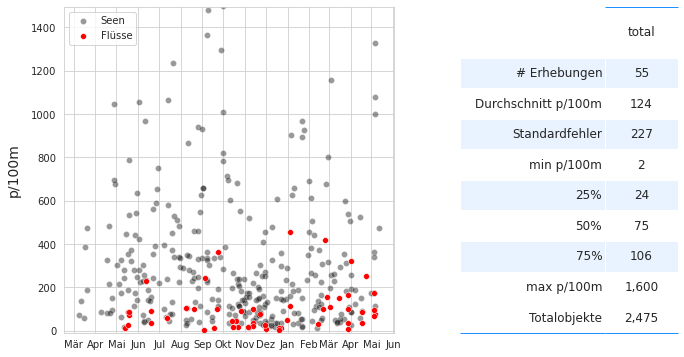

In [14]:
rivers = fd[fd.w_t == "r"].copy()
r_smps = rivers.groupby(["loc_date", "date", "location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)
l_smps = fd[fd.w_t == "l"].groupby(["loc_date","date","location", "water_name_slug"], as_index=False).agg(agg_pcs_quantity)

cs = r_smps[unit_label].describe().round(2)

# add project totals
cs["total objects"] = r_smps.quantity.sum()

# change the names
csx = sut.change_series_index_labels(cs, sut.create_summary_table_index(unit_label, lang="DE"))

combined_summary = sut.fmt_combined_summary(csx, nf=[])

# make the charts
fig = plt.figure(figsize=(11,6))

aspec = fig.add_gridspec(ncols=11, nrows=3)

ax = fig.add_subplot(aspec[:, :6])

line_label = F"{rate} median:{top_name[0]}"

sns.scatterplot(data=l_smps, x="date", y=unit_label, color="black", alpha=0.4, label="Seen", ax=ax)
sns.scatterplot(data=r_smps, x="date", y=unit_label, color="red", s=34, ec="white",label="Flüsse", ax=ax)

ax.set_ylim(-10,y_limit)

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_major_locator(months_loc)
ax.xaxis.set_major_formatter(months_fmt)

a_col = [top_name[0], "total"]

axone = fig.add_subplot(aspec[:, 7:])
sut.hide_spines_ticks_grids(axone)

table_five = sut.make_a_table(axone, combined_summary,  colLabels=a_col, colWidths=[.5,.25,.25],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_five.get_celld()[(0,0)].get_text().set_text(" ")

glue("rivers_de", fig, display=False)

plt.close()

```{glue:figure} rivers_de
:name: "riversx_de"


` `

```

{numref}`Abbildung {number}: <riversx_de>` *Links:* Gesamtergebnisse der Erhebungen an Flüssen für alle Erhebungsgebiete von 2020-03 bis 2021-05, n=55. Werte über 2324,3 p/100 m sind nicht dargestellt. *Rechts:* Zusammenfassende Daten zu Flüssen.

__Häufigste Objekte__

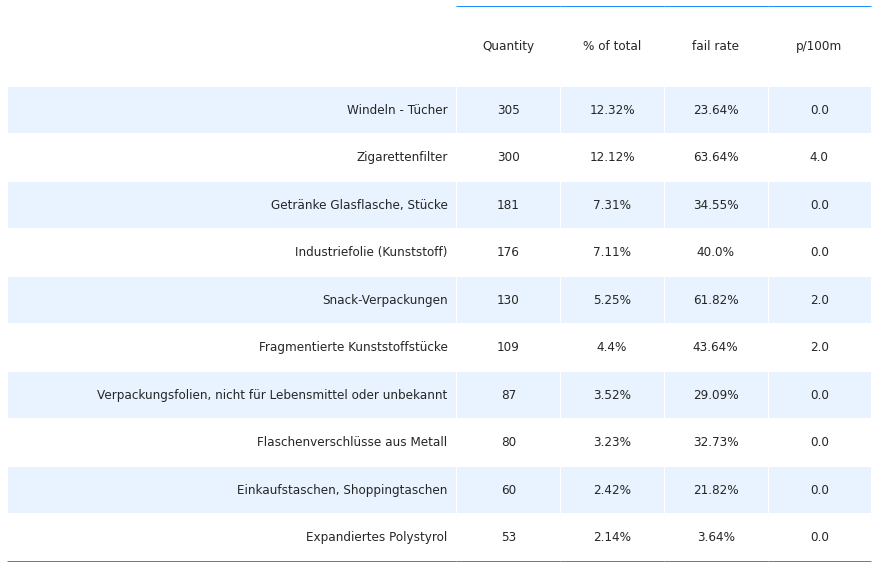

In [15]:
# the most common items rivers
r_codes = rivers.groupby("code").agg({"quantity":"sum", "fail":"sum", unit_label:"median"})
r_codes["fail rate"] = (r_codes.fail/r_smps.loc_date.nunique()*100).round(2)

# top ten
r_byq = r_codes.sort_values(by="quantity", ascending=False)[:10]

# most common
r_byfail = r_codes[r_codes["fail rate"] >= a_fail_rate]
r_common = list(set(r_byq) | set(r_byfail))

r_mc = pd.concat([r_byfail, r_byq]).drop_duplicates()
# format for display
r_mc["item"] = r_mc.index.map(lambda x: code_description_map.loc[x])
r_mc.sort_values(by="quantity", ascending=False, inplace=True)

r_mc["% of total"]=((r_mc.quantity/r_codes.quantity.sum())*100).round(2)
r_mc["% of total"] = r_mc["% of total"].map(lambda x: F"{x}%")
r_mc["quantity"] = r_mc.quantity.map(lambda x: "{:,}".format(x))
r_mc["fail rate"] = r_mc["fail rate"].map(lambda x: F"{x}%")
r_mc[unit_label] = r_mc[unit_label].map(lambda x: F"{np.ceil(x)}")

cols_to_use = {"item":"Item","quantity":"Quantity"}
r_mc.rename(columns=cols_to_use, inplace=True)

data=r_mc[["Item","Quantity", "% of total", "fail rate", unit_label]]

fig, axs = plt.subplots(figsize=(12.3,len(data)*.8))

sut.hide_spines_ticks_grids(axs)

table_six = sut.make_a_table(axs, data.values,  colLabels=data.columns, colWidths=[.52, .12,.12,.12, .12],  bbox=[0,0,1,1], **{"loc":"lower center"})
table_six.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
glue("rivers2_de", fig, display=False)
plt.close()

```{glue:figure} rivers2_de
:name: "rivers_2_de"


` `

```

{numref}`Abbildung {number}: <rivers_2_de>` Die häufigsten Objekte aus Erhebungen an Flüssen. Windel – Tücher und Plastiktüten sind nicht unter den häufigsten Gegenständen, wenn Seen berücksichtigt werden.

## Annex

### Schaumstoffe und Kunststoffe nach Größe 

Die folgende Tabelle enthält die Komponenten «Gfoam» und «Gfrags», die für die Analyse gruppiert wurden. Objekte, die als Schaumstoffe gekennzeichnet sind, werden als Gfoam gruppiert und umfassen alle geschäumten Polystyrol-Kunststoffe > 0,5 cm.  Kunststoffteile und Objekte aus kombinierten Kunststoff- und Schaumstoffmaterialien > 0,5 cm werden für die Analyse als Gfrags gruppiert. 

In [16]:
frag_foams = F"""
*{top_name[0]} fragmented foams and plastics by size group.* 
"""
md(frag_foams)


*Alle Erhebungsgebiete fragmented foams and plastics by size group.* 


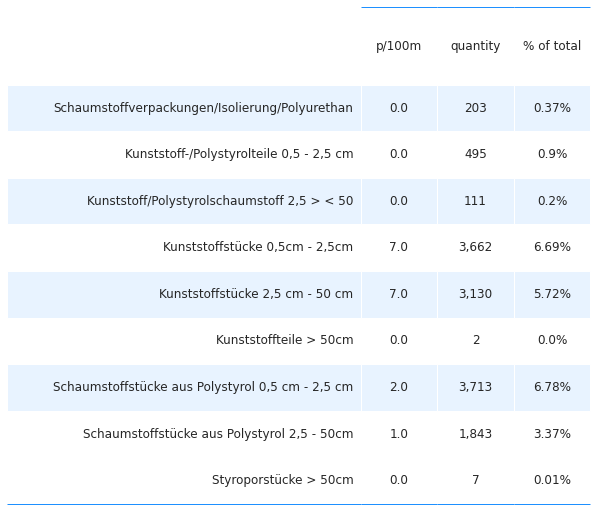

In [17]:
# collect the data before aggregating foams for all locations in the survye area
# group by loc_date and code
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ["G81", "G82", "G83", "G74"]

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == "plastic pieces"].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(fd.location.unique()))].groupby(["loc_date","code"], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby("code").agg({unit_label:"median", "quantity":"sum"})

# add code description and format for printing
fd_frags_foams["item"] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams["% of total"] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams["% of total"] = fd_frags_foams["% of total"].map(lambda x: F"{x}%")
fd_frags_foams["quantity"] = fd_frags_foams["quantity"].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[["item",unit_label, "quantity", "% of total"]]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.8))
sut.hide_spines_ticks_grids(axs)

table_seven = sut.make_a_table(axs, data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13],a_color=a_color)
table_seven.get_celld()[(0,0)].get_text().set_text(" ")

plt.tight_layout()
plt.show()

### Organisationen:

1. Precious Plastic Léman
2. Association pour la Sauvegarde du Léman
3. Geneva international School
4. Solid waste engineering students: École polytechnique fédéral Lausanne
5. Summit foundation
6. University of Raperswill
7. Hackuarium

### Gemeinden, Seen und Flüsse mit Erhebungen

In [18]:
lakes = dfBeaches.loc[(dfBeaches.index.isin(fd.location.unique()))&(dfBeaches.water == "l")]["water_name"].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd.location.unique()))&(dfBeaches.water == "r")]["water_name"].unique()


# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][["city","population"]].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index("city", drop=True, inplace=True)
munis_joined = ", ".join(sorted(fd_pop_map.index))

muni_string = F"""**Gemeinden:**\n\n >{munis_joined}
"""
md(muni_string)

**Gemeinden:**

 >Aarau, Allaman, Ascona, Beatenberg, Bellinzona, Bern, Biel/Bienne, Boudry, Bourg-en-Lavaux, Brienz (BE), Brissago, Brugg, Brügg, Burgdorf, Bönigen, Cheyres-Châbles, Cudrefin, Dietikon, Erlach, Estavayer, Freienbach, Gals, Gambarogno, Gebenstorf, Genève, Gland, Glarus Nord, Grandson, Hauterive (NE), Hünenberg, Kallnach, Köniz, Küsnacht (ZH), La Tour-de-Peilz, Lausanne, Lavey-Morcles, Le Landeron, Leuk, Ligerz, Locarno, Lugano, Luterbach, Lüscherz, Merenschwand, Minusio, Montreux, Neuchâtel, Nidau, Port, Préverenges, Quarten, Rapperswil-Jona, Richterswil, Riddes, Rubigen, Saint-Gingolph, Saint-Sulpice (VD), Salgesch, Schmerikon, Sion, Solothurn, Spiez, Stäfa, Thun, Tolochenaz, Unterengstringen, Unterseen, Versoix, Vevey, Vinelz, Walenstadt, Walperswil, Weesen, Weggis, Yverdon-les-Bains, Zug, Zürich


In [19]:
lakes_joined = ", ".join(sorted(lakes))

lake_string = F"""**Seen:**\n\n >{lakes_joined}
"""
md(lake_string)

**Seen:**

 >Bielersee, Brienzersee, Lac Léman, Lago Maggiore, Lago di Lugano, Neuenburgersee, Quatre Cantons, Thunersee, Walensee, Zugersee, Zurichsee


In [20]:
rivers_joined = ", ".join(sorted(rivers))

river_string = F"""**Flüsse:**\n\n >{rivers_joined}
"""
md(river_string)

**Flüsse:**

 >Aare, Aare|Nidau-Büren-Kanal, Cassarate, Dorfbach, Emme, Escherkanal, Jona, La Thièle, Limmat, Linthkanal, Maggia, Reuss, Rhône, Schüss, Seez, Sihl, Ticino


In [21]:
# summary statistics:
# number of samples
fd_n_samps = len(dt_all)
# quantity
fd_n_obj = fd.quantity.sum()
# number of locations
fd_n_locs = fd.location.nunique()
# number of cities
fd_n_munis = len(fd_pop_map.index)
# populations
fd_effected_population = fd_pop_map.sum()
# list of locations
fd_locs = fd.location.unique()
# list of survey keys
fd_samps = fd.loc_date.unique()


obj_string = "{:,}".format(fd_n_obj)
surv_string = "{:,}".format(fd_n_samps)
pop_string = "{:,}".format(int(fd_effected_population[0]))

date_quantity_context = F"Für den Zeitraum zwischen {start_date[:-3]} und {end_date[:-3]}, wurden im Rahmen von {surv_string} Datenerhebungen insgesamt {obj_string } Objekte entfernt und identifiziert."
geo_context = F"Die Ergebnisse des Aare-Erhebungsgebiets umfassen {fd_n_locs} Orte,  {fd_n_munis } Gemeinden und eine Gesamtbevölkerung von etwa {pop_string} Einwohnern."

# date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
# geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
# admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}."
md(F"{date_quantity_context} {geo_context }")

Für den Zeitraum zwischen 01.03.2 und 31.09.2, wurden im Rahmen von 386 Datenerhebungen insgesamt 54,744 Objekte entfernt und identifiziert. Die Ergebnisse des Aare-Erhebungsgebiets umfassen 143 Orte,  77 Gemeinden und eine Gesamtbevölkerung von etwa 1,735,991 Einwohnern.

In [22]:
# display the survey locations

pd.set_option("display.max_rows", None)
disp_columns = ["latitude", "longitude", "city"]
disp_beaches = dfBeaches.loc[fd_locs][disp_columns]
new_names = {"slug":"Standort", "city":"Stadt"}
disp_beaches.reset_index(inplace=True)
disp_beaches.rename(columns=new_names, inplace=True)
disp_beaches.set_index("Standort", inplace=True, drop=True)

disp_beaches

,latitude,longitude,Stadt
Standort,,,
maladaire,46.446296,6.876960,La Tour-de-Peilz
preverenges,46.512690,6.527657,Préverenges
caprino,45.987963,8.986241,Lugano
foce-del-cassarate,46.002411,8.961477,Lugano
lido,46.002004,8.962156,Lugano
lugano-centro,46.002627,8.950724,Lugano
spiaggia-parco-ciani,46.002510,8.960820,Lugano
via-brunari-spiaggia,46.202350,9.016910,Bellinzona
golene-gudo,46.170655,8.946657,Bellinzona


In [23]:

complete_inventory = code_totals[code_totals.quantity>0][["item", "groupname", "quantity", "% of total","fail rate"]]

new_names = {"item":"Objekte", "groupname":"Gruppenname", "quantity":"Menge", "fail rate":"Fail-Pass", "% of total":"% Gesamt", }

complete_inventory.rename(columns=new_names, inplace=True)
complete_inventory.sort_values(by="Menge", ascending=False)

,Objekte,Gruppenname,Menge,% Gesamt,Fail-Pass
code,,,,,
G27,Zigarettenfilter,Tabak,8485,15.50,87
Gfrags,Fragmentierte Kunststoffstücke,Plastikfragmente,7400,13.52,86
Gfoam,Expandiertes Polystyrol,Infrastruktur,5563,10.16,68
G30,Snack-Verpackungen,Essen und Trinken,3325,6.07,85
G67,Industriefolie (Kunststoff),Landwirtschaft,2534,4.63,69
G200,"Getränke Glasflasche, Stücke",Essen und Trinken,2136,3.90,65
G112,Industriepellets (Nurdles),Mikroplastik (< 5mm),1968,3.59,30
G74,Schaumstoffverpackungen/Isolierung/Polyurethan,Infrastruktur,1702,3.11,53
G95,Wattestäbchen,Abwasser,1406,2.57,50
